In [1]:
import pandas as pd
import numpy as np

This is a test with a small dataset 

In [2]:
sf3 = pd.read_csv('data/data_2q/sf_holdings_1000i_1000t.csv')
sf3 = sf3.dropna()
ticker_list=sf3['ticker'].unique()
ticker_list.sort()
investor_list=sf3['investorname'].unique()
calendar_list=sf3['calendardate'].unique()

print(f'number of tickers: {len(ticker_list)} number of innvesters: {len(investor_list)} number of calendar dates: {len(calendar_list)}')


number of tickers: 1000 number of innvesters: 999 number of calendar dates: 1


In [4]:
#train_data=pd.read_csv("data/train_data.csv")
#validate_data=pd.read_csv("data/validate_data.csv")
#len(train_data)
#train_data=train_data.dropna()
#validate_data=validate_data.dropna()
#train_data.head()
##replace the date dimension input with just the the dates from the training data,
#calendar_list=train_data['calendardate'].unique()

In [3]:
dim_dates=calendar_list
num_dates=len(dim_dates)
dim_tickers=ticker_list
num_tickers=len(dim_tickers)
dim_investors=investor_list
num_investors=len(dim_investors)

#dim_tickers=['ticker'+str(i) for i in range(num_tickers)]
#dim_investors=['investor'+str(i) for i in range(num_investors)]
dim_investors

array(['VANGUARD GROUP INC', 'FMR LLC', 'STATE STREET CORP',
       'BNP PARIBAS ARBITRAGE SNC', 'JPMORGAN CHASE CO',
       'BLACKROCK INSTITUTIONAL TRUST COMPANY NA',
       'CAPITAL WORLD INVESTORS', 'PNC FINANCIAL SERVICES GROUP INC',
       'PRICE T ROWE ASSOCIATES INC', 'CAPITAL RESEARCH GLOBAL INVESTORS',
       'MORGAN STANLEY', 'SUSQUEHANNA INTERNATIONAL GROUP LLP',
       'CITIGROUP INC', 'GOLDMAN SACHS GROUP INC', 'BANK OF AMERICA CORP',
       'BARCLAYS PLC', 'MANUFACTURERS LIFE INSURANCE COMPANY THE',
       'CREDIT SUISSE AG 1', 'WELLINGTON MANAGEMENT GROUP LLP',
       'ROYAL BANK OF CANADA', 'INVESCO LTD', 'NORTHERN TRUST CORP',
       'BANK OF NEW YORK MELLON CORP', 'BLACKROCK FUND ADVISORS',
       'PRIMECAP MANAGEMENT CO', 'JEFFERIES GROUP INC',
       'SCHRODER INVESTMENT MANAGEMENT GROUP', 'BAILLIE GIFFORD CO',
       'DEUTSCHE BANK AG', 'MASSACHUSETTS FINANCIAL SERVICES CO',
       'BRIDGEWATER ASSOCIATES LP', 'BANK OF MONTREAL',
       'FRANKLIN RESOURCES INC', '

In [4]:
train_data=sf3
train_data.shape
dim_tickers_dates=[(ticker,dt) for ticker in dim_tickers for dt in dim_dates]
dim_tickers_dates[0:5]

[('A', '2013-12-31'),
 ('AAL', '2013-12-31'),
 ('AAP', '2013-12-31'),
 ('AAPL', '2013-12-31'),
 ('ABB', '2013-12-31')]

Add negative examples (fund does not own the ticker)
I will add an equal number of tickers, not juist

In [5]:
import random
# Drop unwanted columns
df_train = train_data[['ticker', 'calendardate', 'investorname']]

# Replace 'value' column with 1
df_train['value'] = 1

# Length of dataframe
print('Length of dataframe:', len(df_train))

# Generate list of tuples from df_train for checking existence later
existing_combinations = set(tuple(x) for x in df_train[['ticker', 'calendardate', 'investorname']].to_numpy())

# Generate new list of dictionaries
new_data = []
for _ in range(len(df_train)):
    while True:
        ticker_date = random.choice(dim_tickers_dates)
        investor = random.choice(dim_investors)
        combination = (ticker_date[0], ticker_date[1], investor)
        if combination not in existing_combinations:
            new_data.append({
                'ticker': combination[0],
                'calendardate': combination[1],
                'investorname': combination[2],
                'value': 0
            })
            break

# Convert list of dictionaries to DataFrame
df_new = pd.DataFrame(new_data)

# Append new DataFrame to original DataFrame
df_train = pd.concat([df_train, df_new], ignore_index=True)
print('Length of dataframe after adding negative samnples:', len(df_train))

/var/folders/c1/dv7w7b2x49j3spqsxnz6y_sw0000gn/T/ipykernel_83538/2541709021.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['value'] = 1


Length of dataframe: 413306
Length of dataframe after adding negative samnples: 826612


Create a dataset with entries for zeros, alternative is to use contrasting learning

In [6]:
from sklearn.model_selection import train_test_split
#pick the dataset
df_out=df_train
#df_out=df_positive
#o Split the DataFrame into training and test sets
#df_ train will be 5% of the original DataFrame, i just want to see if it runs, because its really slow
df_train2, df_test = train_test_split(df_train, test_size=0.2, random_state=42)
df_out=df_train
len(df_out)

826612

This could be split into a different notebook

In [7]:
# Custom dataset class

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


class SF3Dataset(Dataset):
    def __init__(self, sf3, investor2idx, ticker2idx, date2idx,ticker_date2idx):
        self.sf3 = sf3
        self.investor2idx = investor2idx
        self.ticker2idx = ticker2idx
        self.date2idx = date2idx
        self.ticker_date2idx = ticker_date2idx

    def __len__(self):
        return len(self.sf3)

    def __getitem__(self, idx):
        row = self.sf3.iloc[idx]
        #print(f'__getitem__ row={row}')
        row=row.to_dict()
        #print(f'__getitem__ row={row}')
        investor_idx = self.investor2idx[row['investorname']]
        #print (f'investor_idx={investor_idx}')
        stock_idx = self.ticker2idx[row['ticker']]
        date_idx = self.date2idx[row['calendardate']]
        ticker_date2idx=self.ticker_date2idx[(row['ticker'],row['calendardate'])]
        target = torch.tensor(float(row['value']), dtype=torch.float)
        #print(f'investor_idx={investor_idx}, stock_idx={stock_idx}, date_idx={date_idx}, target={target}')
        return investor_idx, stock_idx, date_idx, ticker_date2idx ,target
    

# Custom collate_fn

def sf3_collate_fn(batch):
    #print(f'batch={batch}')
    investor_list = []
    stock_list = []
    date_list = []
    target_list = []
    for investor, stock, date, target in batch:
        investor_list.append(investor)
        stock_list.append(stock)
        date_list.append(date)
        target_list.append(target)
    return torch.tensor(investor_list), torch.tensor(stock_list), torch.tensor(date_list), torch.tensor(target_list)

# Create the dataset and dataloader

    

In [8]:
# Define the model
import torch.nn.init as init


class MatrixFactorization(nn.Module):
    def __init__(self, num_investors, embedding_dim, num_tickers, num_dates, ticker_embedding_dim, date_embedding_dim):
        super().__init__()
        self.investor_embeddings = nn.Embedding(num_investors, embedding_dim)
        self.ticker_embeddings = nn.Embedding(num_tickers, ticker_embedding_dim)
        self.date_embeddings = nn.Embedding(num_dates, date_embedding_dim)
        self.ticker_date_embeddings = nn.Embedding(num_tickers*num_dates, ticker_embedding_dim + date_embedding_dim)
        initrange = 0.5 / embedding_dim
        init.uniform_(self.investor_embeddings.weight, -initrange, initrange)
        init.uniform_(self.ticker_embeddings.weight, -initrange, initrange)
        init.uniform_(self.date_embeddings.weight, -initrange, initrange)
        init.uniform_(self.ticker_date_embeddings.weight, -initrange, initrange)


        
    def forward(self, investor_ids, ticker_ids, date_ids,ticker_date_ids):
        investor_embeds = self.investor_embeddings(investor_ids)
        ticker_embeds = self.ticker_embeddings(ticker_ids)
        date_embeds = self.date_embeddings(date_ids)
        #ticker_date_embeds = torch.cat([ticker_embeds, date_embeds], 1)
        ticker_date_embeds = self.ticker_date_embeddings(ticker_date_ids)
        result=torch.sigmoid((investor_embeds * ticker_date_embeds).sum(dim=1))
        #if I want to use a linear layer instead of sigmoid
        return result

In [9]:
def get_sf3_dims(df):
    """
    inputs:
        df: dataframe
    outputs:
        ticker_list: list of tickers
        date_list: list of dates
        investorname_name_list: list of investor names
    """
    ticker_list = df.ticker.unique().tolist()
    date_list = df.calendardate.unique().tolist()
    investorname_name_list = df.investorname.unique().tolist()
    return ticker_list, date_list, investorname_name_list

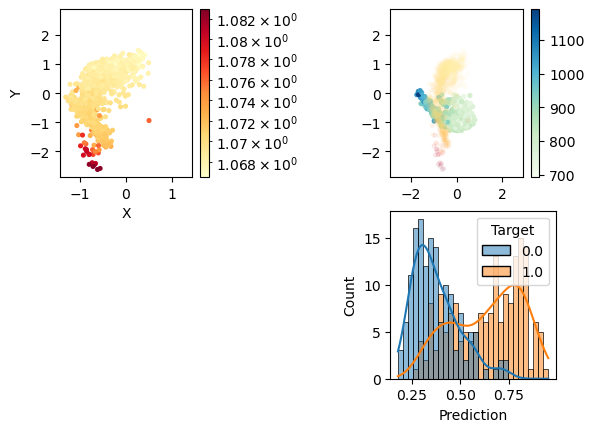

Epoch 1/50, Loss: 0.5493349320871221, Valid Loss: 0.489638477384326


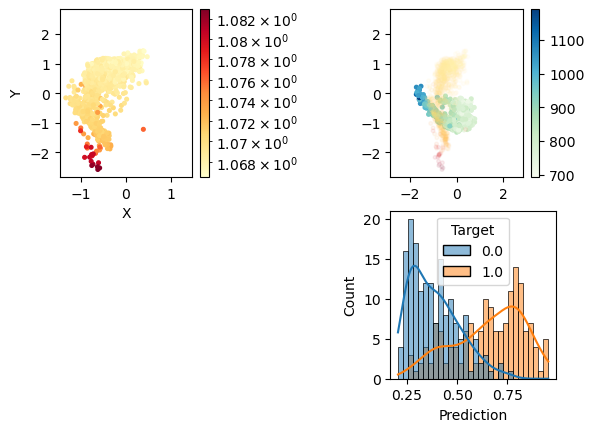

Epoch 2/50, Loss: 0.490338146037894, Valid Loss: 0.48770842027951433


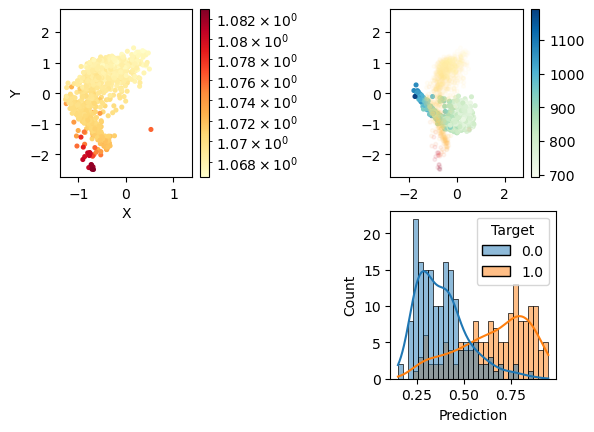

Epoch 3/50, Loss: 0.48997172709676057, Valid Loss: 0.48813314699983024


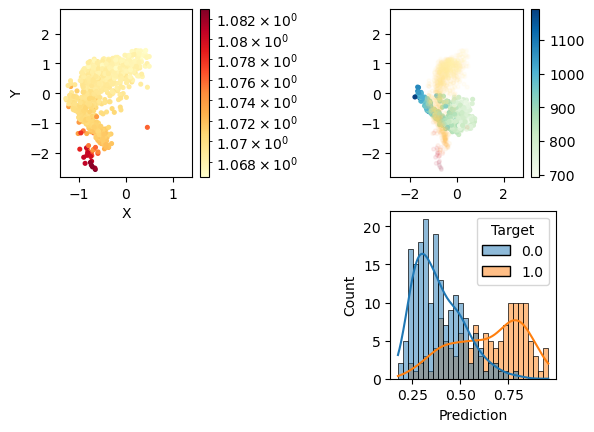

Epoch 4/50, Loss: 0.4897720662036859, Valid Loss: 0.488010858017278


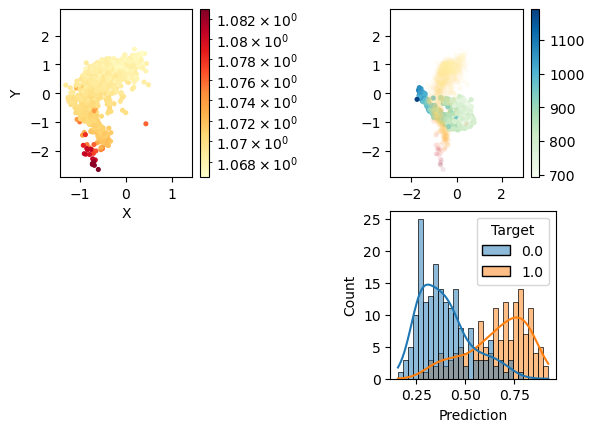

Epoch 5/50, Loss: 0.489714346096334, Valid Loss: 0.48898850363421154


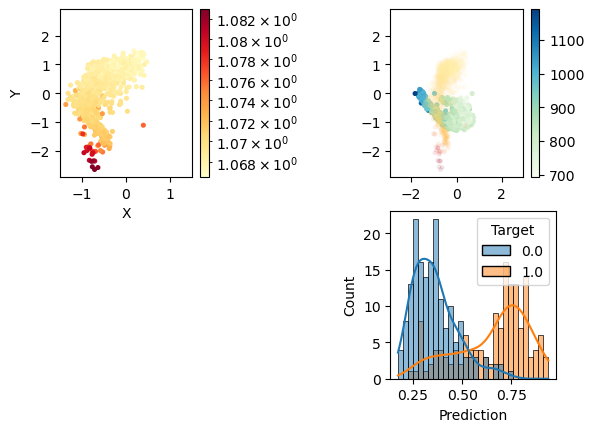

Epoch 6/50, Loss: 0.48998239780567865, Valid Loss: 0.4881325015820653


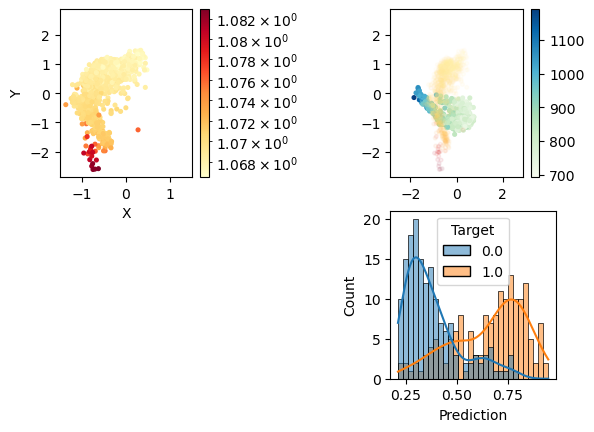

Epoch 7/50, Loss: 0.4897664991875225, Valid Loss: 0.48836869162967406


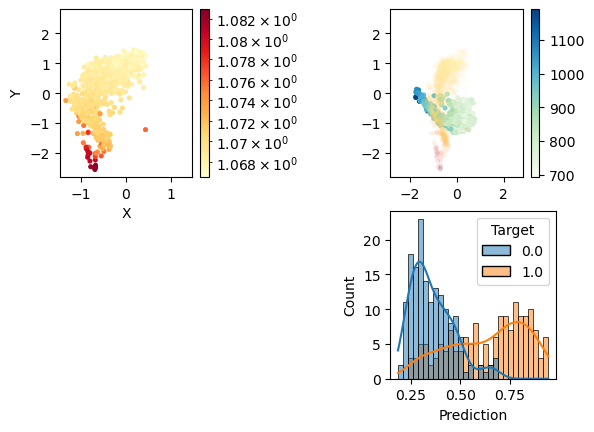

Epoch 8/50, Loss: 0.4898992060461817, Valid Loss: 0.48776654414383763


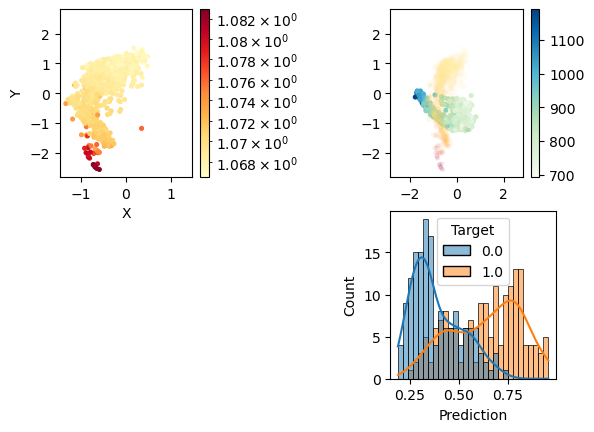

Epoch 9/50, Loss: 0.4897510677107588, Valid Loss: 0.4881884188178074


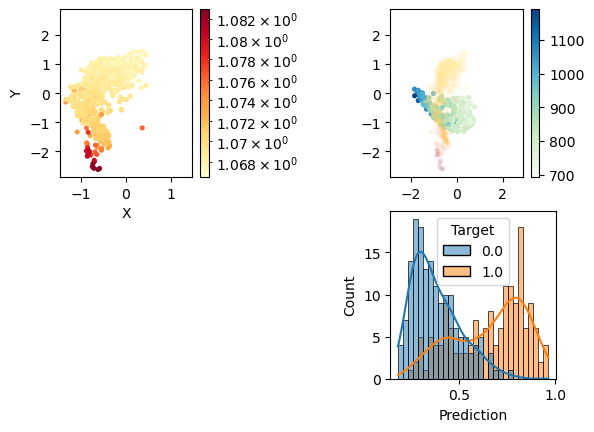

Epoch 10/50, Loss: 0.4898717106830108, Valid Loss: 0.4877595147454595


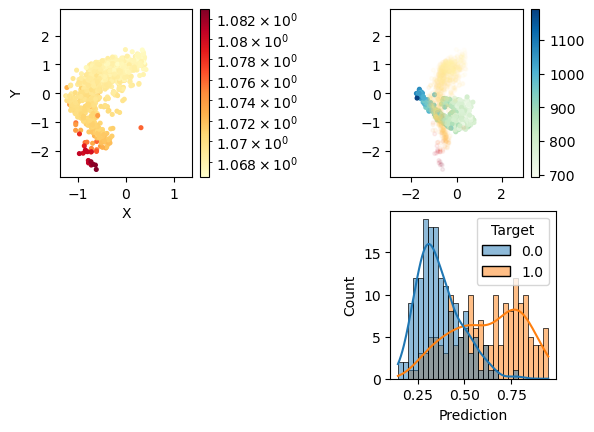

Epoch 11/50, Loss: 0.48976044700973126, Valid Loss: 0.4880956585507795


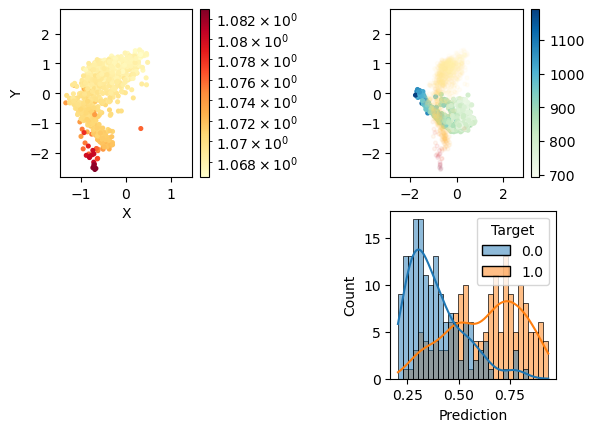

Epoch 12/50, Loss: 0.48977355386931204, Valid Loss: 0.4882211180695568


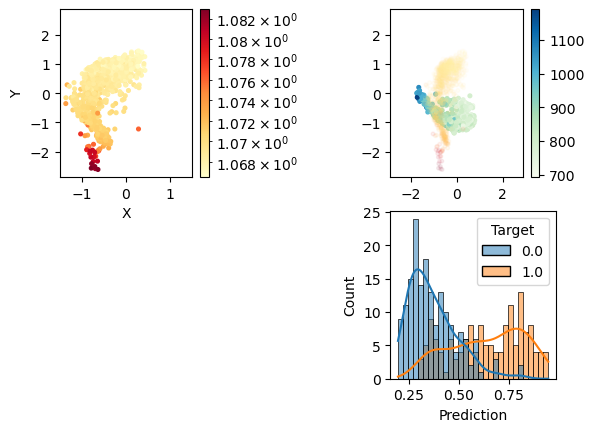

Epoch 13/50, Loss: 0.489878501864702, Valid Loss: 0.4880569149930793


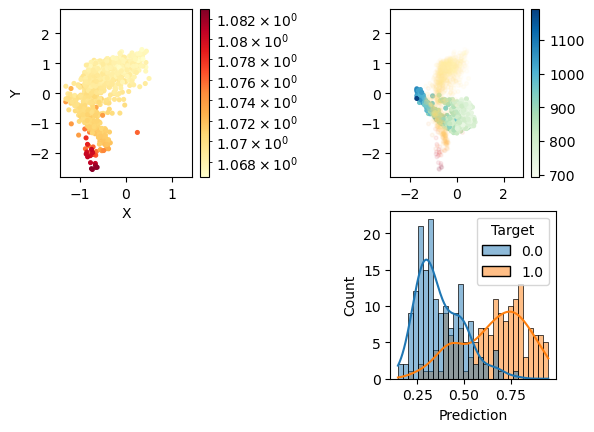

Epoch 14/50, Loss: 0.4897777017255504, Valid Loss: 0.48851930789918785


KeyboardInterrupt: 

In [14]:
from IPython.display import clear_output
investor_name_list=dim_investors
ticker_list=dim_tickers
investorname_list=dim_investors

date_list=dim_dates
val_df=df_test
df_train_local=df_train
# Create dictionaries for mapping
#investor2idx = {investor: idx for idx, investor in enumerate(investorname_list)}
investor2idx = {investor: idx for idx, investor in enumerate(dim_investors)}
ticker_date2idx = {(ticker, date): idx for idx, (ticker, date) in enumerate([(ticker, date) for ticker in dim_tickers for date in dim_dates])}
#returns_idx=[returns[idx_date, idx_ticker] for (idx_ticker, idx_date)in list(ticker_date2idx.values())]
ticker2idx = {ticker: idx for idx, ticker in enumerate(ticker_list)}
date2idx = {date: idx for idx, date in enumerate(date_list)}
batch_size = 1000

sf3_dataset = SF3Dataset(df_train_local, investor2idx, ticker2idx, date2idx, ticker_date2idx)
data_loader = DataLoader(sf3_dataset, batch_size=batch_size, shuffle=True)
valid_dataset=SF3Dataset(val_df, investor2idx, ticker2idx, date2idx, ticker_date2idx)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
#returns_idx=[returns[idx_date,idx_ticker] for idx_ticker in range (len(dim_tickers)) for idx_date in range(len(dim_dates))]
#ratings_idx=[ratings[idx_date,idx_ticker] for idx_ticker in range (len(dim_tickers)) for idx_date in range(len(dim_dates))]


# Hyperparameters
embedding_dim = 2
ticker_embedding_dim =1
date_embedding_dim = 1
learning_rate = 0.01
num_epochs = 50

model = MatrixFactorization(len(investorname_list), embedding_dim, len(ticker_list), len(date_list), ticker_embedding_dim, date_embedding_dim)

#criterion = nn.MSELoss()
criterion = nn.BCELoss()

weight_decay = 1e-4 # L2 regularization
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Training loop
%matplotlib inline
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    all_targets=[]
    all_predictions=[]
    num_points=0
    #print(f'total batches={len(data_loader)}')
    #print(f'size of data set={len(sf3_dataset)}')
    #print(f'size of sf3 dataset={len(sf3)}')
    for batch_idx, (investor_indices, stock_indices, date_indices, ticker_date_indeces, targets) in enumerate(data_loader):
        # Convert lists to tensorsf
        #print(f'investor_indices={investor_indices}')
        #investor_indices = torch.tensor(investor_indices, dtype=torch.long)
        #stock_indices = torch.tensor(stock_indices, dtype=torch.long)
        #date_indices = torch.tensor(date_indices, dtype=torch.long)
        #print(f'eopch={epoch}, batch_idx={batch_idx}, investor_indeces.shape={investor_indices.shape}')

        #all_targets=[]
        #all_predictions=[]
        optimizer.zero_grad()
        predictions = model(investor_indices, stock_indices, date_indices,ticker_date_indeces)
        loss = criterion(predictions, torch.sign(targets))
        all_targets.append(np.sign(targets))
        all_predictions.append(predictions)
        num_points+=len(targets)
        #if((batch_idx%100)==0):
        #    print(f'targets={targets}')
        #    print(f'predictions={predictions}')
            #print(f'sum()')
        #print(f'epoch={epoch}, batch_idx={batch_idx}, sum of targets={np.sum(np.sign(targets),axis=0)}, sum of predictions={np.sum(predictions,axis=0)}')
        # Apply L1 regularization
        #l1_lambda = 0.001
        #l1_penalty = 0

        #for param in model.parameters():
        #    l1_penalty += torch.abs(param).sum()

        #loss += l1_lambda * l1_penalty

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #if((epoch%3)==1):
    
    valid_loss=0
    
    for batch_idx, (investor_indices, stock_indices, date_indices, ticker_date_indeces, targets) in enumerate(valid_loader):
        all_targets=[]
        all_predictions=[]
        optimizer.zero_grad()
        predictions = model(investor_indices, stock_indices, date_indices,ticker_date_indeces)
        loss = criterion(predictions, np.sign(targets))
        all_targets.append(np.sign(targets))
        all_predictions.append(predictions)
        valid_loss += loss.item()
    #print(f'epoch={epoch}, batch_idx={batch_idx}, loss={loss.item()}')
    #plot_inv_embeddings()
    plot_inv_embeddings()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(data_loader)}, Valid Loss: {valid_loss/len(valid_loader)}")
    #clear_output(wait=True)

    #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(sf3_dataset)}, Valid Loss: {valid_loss/len(valid_dataset)}")
    


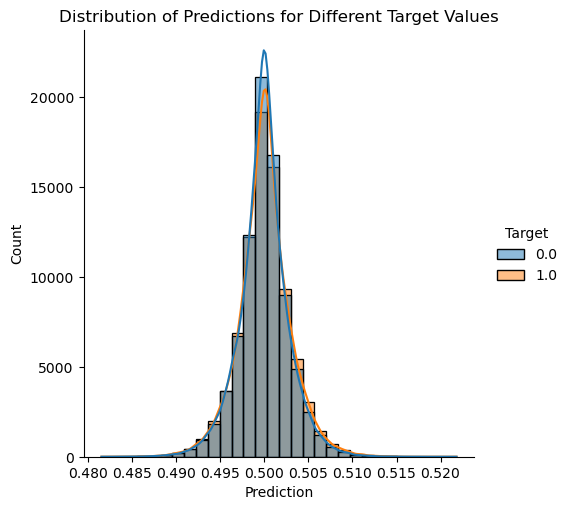

In [11]:
import matplotlib.pyplot as plt
valid_loss=0
all_targets=[]
all_predictions=[]
for batch_idx, (investor_indices, stock_indices, date_indices, ticker_date_indeces, targets) in enumerate(valid_loader):
    optimizer.zero_grad()
    predictions = model(investor_indices, stock_indices, date_indices,ticker_date_indeces)
    loss = criterion(predictions, np.sign(targets))
    all_targets.append(np.sign(targets))
    all_predictions.append(predictions)
    valid_loss += loss.item()
    #print(f'epoch={epoch}, batch_idx={batch_idx}, loss={loss.item()}')
all_targets_flat = torch.cat(all_targets)
all_predictions_flat = torch.cat(all_predictions)
all_predictions_np = all_predictions_flat.detach().numpy()
all_targets_np = all_targets_flat.detach().numpy()

# Create a DataFrame with target and prediction columns
data = pd.DataFrame({'Target': all_targets_np, 'Prediction': all_predictions_np})
import seaborn as sns
# Create histograms for different target values
sns.displot(data=data, x='Prediction', hue='Target', kind='hist', kde=True, bins=30)
plt.title('Distribution of Predictions for Different Target Values')
plt.show()

In [12]:
labels=np.zeros(model.investor_embeddings.weight.data.shape[0])

labels.shape
labels=np.zeros(model.investor_embeddings.weight.data.shape[0])+1
returns_idx=labels
ratings_idx=labels
labels.shape

investor_count = df_train.groupby('investorname').count()
investor_count = investor_count.sort_values(by=['ticker'], ascending=False)
investor_count = investor_count.reset_index()
investor_count = investor_count[['investorname', 'ticker']]
investor_count = investor_count.rename(columns={"ticker": "count"})
investor2idx.keys()
#investor_count
inv_stocks_owned=np.zeros(model.investor_embeddings.weight.data.shape[0])
for i in range(len(investor_count)):
    inv_stocks_owned[investor2idx[investor_count.iloc[i]['investorname']]]=investor_count.iloc[i]['count']

inv_stocks_owned



ticker_count = df_train.groupby('ticker').count()

ticker_count = ticker_count.sort_values(by=['investorname'], ascending=False)
ticker_count = ticker_count.reset_index()
ticker_count = ticker_count[['ticker', 'investorname']]
ticker_count = ticker_count.rename(columns={"investorname": "count"})

#investor_count
ticker_inv_owned=np.zeros(model.ticker_date_embeddings.weight.data.shape[0])
for i in range(len(ticker_count)):
    dim_key=(ticker_count.iloc[i]['ticker'],dim_dates[0])
    ticker_inv_owned[ticker_date2idx[dim_key]]=ticker_count.iloc[i]['count']




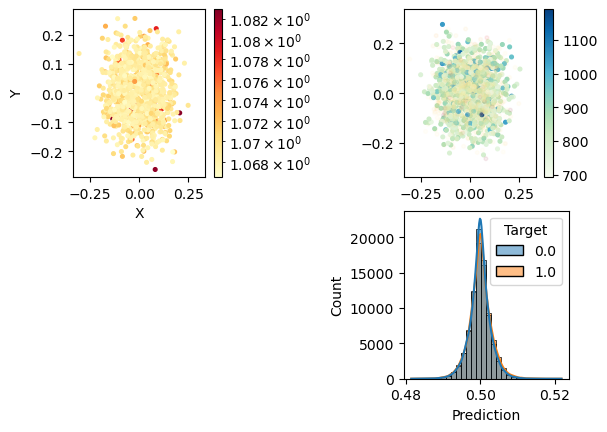

In [13]:
import matplotlib.colors as colors
def plot_inv_embeddings():
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    labels=np.zeros(model.investor_embeddings.weight.data.shape[0])

    #labels[pref_factor1==-1]=1
    #labels[pref_factor1==1]=2
    #labels[pref_factor2==-1]=3
    #labels[pref_factor2==1]=4
    #colors={1:'yellow',2:'red',3:'green',4:'blue'}
    labels=np.zeros(model.investor_embeddings.weight.data.shape[0])+1
    returns_idx=np.zeros(model.ticker_date_embeddings.weight.data.shape[0])+1
    ratings_idx=np.zeros(model.ticker_date_embeddings.weight.data.shape[0])+1

    #point_colors = [colors[label] for label in labels]


# Generate random 3D embeddings (replace this with your actual embeddings)
    #embeddings = np.random.rand(50, 3)

# Extract the x, y, and z coordinates
    x = model.investor_embeddings.weight.data[:, 0]
    y = model.investor_embeddings.weight.data[:, 1]
    if(embedding_dim>=3):
        z = model.investor_embeddings.weight.data[:, 2]
    else:
        z=np.zeros_like(x)
    #z = model.investor_embeddings.weight.data[:, 2]


    x2 = model.ticker_date_embeddings.weight.data[:, 0]
    y2 = model.ticker_date_embeddings.weight.data[:, 1]
    if(embedding_dim>=3):
        z2 = model.ticker_date_embeddings.weight.data[:, 2]
    else:
        z2=np.zeros_like(x2)
    #z2 = model.ticker_date_embeddings.weight.data[:, 2]
    #z=np.zeros_like(x)

# Create a 3D scatter plot
    fig = plt.figure()
    if(embedding_dim>=3):
        ax = fig.add_subplot(221, projection='3d')
        ax2= fig.add_subplot(222, projection='3d')
        #ax3= fig.add_subplot(223, projection='3d')
        ax4= fig.add_subplot(224)
    else:
        ax = fig.add_subplot(221)
        ax2= fig.add_subplot(222)
        #ax3= fig.add_subplot(233)
        ax4= fig.add_subplot(224)
    
    #ax = fig.add_subplot(111)

    max_abs_x = [max(abs(x.min()), abs(x.max()))*1.1 for x in [x, x2]]
    x_max=np.max(max_abs_x)
    max_abs_y = [max(abs(y.min()), abs(y.max()))*1.1 for y in [y, y2]]
    y_max=np.max(max_abs_y)
    xy_max=max(x_max,y_max)
    norm1 = colors.LogNorm(vmin=(inv_stocks_owned**0.01).min(), vmax=(inv_stocks_owned**0.01).max(), clip=True)
    if(embedding_dim>=3):
        scatter1=ax.scatter(x, y, z,norm=norm1, c=inv_stocks_owned**0.01,cmap='YlOrRd', s=7)
        #ax.legend()
        scatter2=ax2.scatter(x2, y2, z2,c=ticker_inv_owned,cmap='GnBu',s=7)
        #scatter3=ax3.scatter(x2, y2, z2, c=ratings_idx, cmap='GnBu')
    else:
        scatter1=ax.scatter(x, y,norm=norm1, c=inv_stocks_owned**0.01,cmap='YlOrRd',s=7)
        #ax2.scatter(x2, y2, c=returns_idx, cmap='YlOrRd')
        #ax3.scatter(x2, y2, c=ratings_idx, cmap='GnBu')
        scatter2=ax2.scatter(x2, y2, c=ticker_inv_owned,cmap='GnBu',s=7)
        scatter2a=ax2.scatter(x,y,norm=norm1, c=inv_stocks_owned**0.01,cmap='YlOrRd',s=7,alpha=.07)
        #scatter3=ax3.scatter(x2, y2, c=ratings_idx)

    ax.set_xlim([-max_abs_x[0], max_abs_x[0]])
    ax.set_ylim([-max_abs_y[0], max_abs_y[0]])
    #ax2.set_xlim([-max_abs_x[1], max_abs_x[1]])
    #ax2.set_ylim([-max_abs_y[1], max_abs_y[1]])
    ax2.set_xlim([-xy_max, xy_max])
    ax2.set_ylim([-xy_max, xy_max])
    

    fig.colorbar(scatter1, ax=ax, orientation='vertical')
    fig.colorbar(scatter2, ax=ax2, orientation='vertical')
    #fig.colorbar(scatter3, ax=ax3, orientation='vertical')
    #ax.scatter(x, y, c=point_colors) 
    all_targets_flat = torch.cat(all_targets)
    all_predictions_flat = torch.cat(all_predictions)
    all_predictions_np = all_predictions_flat.detach().numpy()
    all_targets_np = all_targets_flat.detach().numpy()

    # Create a DataFrame with target and prediction columns
    data = pd.DataFrame({'Target': all_targets_np, 'Prediction': all_predictions_np})
    import seaborn as sns
    sns.histplot(data=data, x='Prediction', hue='Target',kde=True, bins=30, ax=ax4)
# Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #ax.set_zlabel('Z')
    #plt.colorbar(ax)
    #plt.colorbar(ax2)
    #plt.colorbar(ax3)

# Show the plot
    plt.subplots_adjust(wspace=1)
    plt.show()

plot_inv_embeddings()

In [102]:
inv_stocks_owned**.5

array([31.06444913, 31.44837039, 32.26453161, 40.08740451, 26.64582519,
       48.07286137, 32.31098884, 53.71219601, 36.49657518, 32.23352292,
       26.92582404, 53.38539126, 31.57530681, 35.53871129, 51.28352562,
       37.40320842, 47.59201614, 25.51470164, 33.10589071, 31.25699922,
       33.85262176, 40.11234224, 31.85906464, 31.60696126, 33.73425559,
       26.55183609, 31.04834939, 31.52776554, 26.38181192, 27.05549852,
       27.64054992, 28.46049894, 29.63106478, 25.90366769, 36.18010503,
       30.96772513, 28.87905816, 25.8069758 , 48.06245936, 27.36786437,
       31.54362059, 26.03843313, 30.9354166 , 29.94995826, 28.63564213,
       30.88689042, 36.40054945, 30.49590136, 27.45906044, 44.98888752,
       31.73326331, 53.44155686, 33.55592347, 40.90232267, 29.12043956,
       26.13426869, 28.0713377 , 31.81194744, 52.02883816, 25.29822128,
       30.16620626, 37.21558813, 29.44486373, 29.86636905, 31.40063694,
       31.06444913, 31.8747549 , 25.01999201, 26.36285265, 33.61

In [168]:

investor_name_list
labels=np.zeros(model.investor_embeddings.weight.data.shape[0])
labels[pref_factor1==-1]=1
labels[pref_factor1==1]=2
labels[pref_factor2==-1]=3
labels[pref_factor2==1]=4
colors={1:'blue',2:'green',3:'yellow',4:'red'}
point_colors = [colors[label] for label in labels]
point_colors
model.investor_embeddings.weight.data[75:99,:]
model.ticker_date_embeddings.weight.data[0:10,:]


tensor([[ 0.3856, -0.3856],
        [ 0.5987, -0.5987],
        [ 0.6253, -0.6253],
        [ 0.4946, -0.4946],
        [ 0.5959, -0.5959],
        [ 0.5494, -0.5494],
        [ 0.4802, -0.4801],
        [ 0.5519, -0.5519],
        [ 0.6251, -0.6251],
        [ 0.5808, -0.5808]])

In [75]:
dim_dates


array(['2013-06-30'], dtype=object)

In [54]:
import numpy as np

# Create synthetic data for returns and ratings
#chatGPT generated test function
num_dates = 5
num_stocks = 7
returns = np.random.rand(num_dates, num_stocks)
ratings = np.random.rand(num_dates, num_stocks)

# Number of stocks to pick
num_picks = 3
print(f"returns:\n{returns[0,:]}")
print(f"ratings:\n{ratings[0,:]}")

# Test the function with different preference factors
test_cases = [
    {"pref_factor1": -1, "pref_factor2": 0},
    {"pref_factor1": 1, "pref_factor2": 0},
    {"pref_factor1": 0, "pref_factor2": -1},
    {"pref_factor1": 0, "pref_factor2": 1},
]

for test_case in test_cases:
    pref_factor1 = test_case["pref_factor1"]
    pref_factor2 = test_case["pref_factor2"]
    
    picked_indices = pick_stocks_on_preference(num_picks, pref_factor1, pref_factor2, returns, ratings)
    
    print(f"Preference factors: {pref_factor1} (returns), {pref_factor2} (ratings)")
    print(f"Picked stock indices:\n{picked_indices}")
    print("-" * 40)


returns:
[0.09362876 0.94418965 0.63779439 0.4784309  0.15442046 0.24275315
 0.13164508]
ratings:
[0.61593677 0.50435518 0.34398955 0.51756773 0.14967263 0.11469336
 0.77293415]
num_picks=3,pref_factor1=-1,pref_factor2=0,num_dates=5,num_stocks=7
Preference factors: -1 (returns), 0 (ratings)
Picked stock indices:
[[6. 3. 4.]
 [5. 4. 3.]
 [5. 6. 1.]
 [0. 6. 4.]
 [0. 1. 2.]]
----------------------------------------
num_picks=3,pref_factor1=1,pref_factor2=0,num_dates=5,num_stocks=7
Preference factors: 1 (returns), 0 (ratings)
Picked stock indices:
[[1. 2. 3.]
 [2. 1. 0.]
 [1. 4. 0.]
 [1. 5. 4.]
 [5. 6. 2.]]
----------------------------------------
num_picks=3,pref_factor1=0,pref_factor2=-1,num_dates=5,num_stocks=7
Preference factors: 0 (returns), -1 (ratings)
Picked stock indices:
[[2. 0. 1.]
 [5. 6. 3.]
 [5. 6. 0.]
 [3. 0. 5.]
 [2. 6. 4.]]
----------------------------------------
num_picks=3,pref_factor1=0,pref_factor2=1,num_dates=5,num_stocks=7
Preference factors: 0 (returns), 1 (ratings

In [34]:
a=np.array([1,0,3])
type(np.sign(a)[0])

numpy.int64

ChatGPT rewrite of my paragraph:

In an attempt to build a recommendation system for institutional investors, we aim to use a collaborative filtering approach. Our goal is to predict stock allocations for funds based on their preferences and other influencing factors. We recognize several challenges in applying traditional collaborative filtering to this problem, including the non-stationary nature of stock features, time delays in data reporting, and the differing scales of fund allocations.

To address these challenges, we propose the following approach:

- Synthetic Data Generation:  We will start by generating synthetic data that allows us to test our model on data with known underlying relationships between preferences, returns, and ratings. Our initial iteration will focus on funds that select stocks based on returns or analyst ratings.
- Feature Engineering: Given the dynamic nature of stock features and fund preferences, we will expand our dataset with features like stock valuation metrics, sector or industry information, market cap, past returns, fund size, investment style, and historical performance.
- Model Development: Our approach begins with a simple matrix factorization model, which we will gradually refine to account for the unique characteristics of our problem. This may include adding time-dependent bias terms or exploring advanced models like neural collaborative filtering to capture nonlinear relationships between features.
- Evaluation: Using synthetic data, we will divide our dataset into training, validation, and test sets. This enables us to train our model, tune hyperparameters, and evaluate performance. With synthetic data, we can assess how effectively our model captures the underlying preferences of funds based on returns and ratings.
- Iterative Improvement: We will iteratively improve our model by incorporating additional features, adjusting the model architecture, and addressing unique problem characteristics (e.g., handling delayed data). This iterative process will continue until our model performs reasonably well on synthetic data.
- After successfully refining our model on synthetic data, we will test it on real-world data and make further adjustments as needed to improve performance.